# Prédiction du Cancer du Sein
Ce notebook propose un pipeline complet pour la détection du cancer du sein.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import joblib

plt.style.use('default')
sns.set_palette('Set2')

In [2]:
df = pd.read_csv('breast-cancer.csv')
print(f'📊 Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes')
df.head()

📊 Dataset chargé : 569 lignes, 32 colonnes


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
print(df.describe())

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

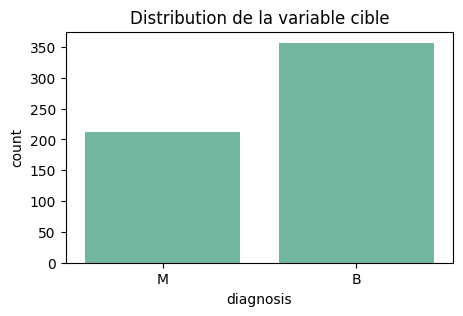

diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


In [5]:
target_col = 'target' if 'target' in df.columns else 'diagnosis'
plt.figure(figsize=(5,3))
sns.countplot(x=target_col, data=df)
plt.title('Distribution de la variable cible')
plt.show()
print(df[target_col].value_counts(normalize=True))

In [6]:

if df[target_col].dtype == 'O':
    df[target_col] = df[target_col].astype('category').cat.codes

X = df.drop(target_col, axis=1)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=10)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)
selected_features = X.columns[selector.get_support()]
print('Features sélectionnées (SelectKBest):', list(selected_features))

Features sélectionnées (SelectKBest): ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [8]:
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=42),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Perceptron': Perceptron(max_iter=1000, random_state=42),
    'PassiveAggressive': PassiveAggressiveClassifier(max_iter=1000, random_state=42)
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f'📊 {name}...')
    scores = []
    for train_idx, val_idx in cv.split(X_train_sel, y_train):
        model.fit(X_train_sel[train_idx], y_train.iloc[train_idx])
        if hasattr(model, 'decision_function'):
            y_score = model.decision_function(X_train_sel[val_idx])
            y_proba = (y_score - y_score.min()) / (y_score.max() - y_score.min())
        elif hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_train_sel[val_idx])[:,1]
        else:
            y_proba = None
        if y_proba is not None:
            scores.append(roc_auc_score(y_train.iloc[val_idx], y_proba))
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    if hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_sel)
        y_proba = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    elif hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_sel)[:,1]
    else:
        y_proba = None
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    results[name] = {
        'model': model,
        'cv_auc_mean': np.mean(scores) if scores else None,
        'cv_auc_std': np.std(scores) if scores else None,
        'test_auc': auc,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    print(f'   CV AUC: {np.mean(scores) if scores else None:.3f} (±{np.std(scores) if scores else None:.3f}) | Test AUC: {auc:.3f}')

stacking = StackingClassifier(
    estimators=[
        ('dt', models['Decision Tree']),
        ('et', models['Extra Trees']),
        ('qda', models['QDA'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    passthrough=True
)
stacking.fit(X_train_sel, y_train)
y_pred_stack = stacking.predict(X_test_sel)
y_proba_stack = stacking.predict_proba(X_test_sel)[:,1]
stack_auc = roc_auc_score(y_test, y_proba_stack)

results['Stacking'] = {
    'model': stacking,
    'cv_auc_mean': np.nan,
    'cv_auc_std': np.nan,
    'test_auc': stack_auc,
    'accuracy': accuracy_score(y_test, y_pred_stack),
    'precision': precision_score(y_test, y_pred_stack),
    'recall': recall_score(y_test, y_pred_stack),
    'f1': f1_score(y_test, y_pred_stack)
}
print(f'📊 Stacking Classifier | Test AUC: {stack_auc:.3f}')

📊 Decision Tree...
   CV AUC: 0.900 (±0.028) | Test AUC: 0.932
📊 Extra Trees...
   CV AUC: 0.986 (±0.009) | Test AUC: 0.997
📊 Bagging...
   CV AUC: 0.986 (±0.009) | Test AUC: 0.997
📊 Bagging...
   CV AUC: 0.979 (±0.010) | Test AUC: 0.990
📊 QDA...
   CV AUC: 0.986 (±0.010) | Test AUC: 0.990
📊 Perceptron...
   CV AUC: 0.987 (±0.012) | Test AUC: 0.998
📊 PassiveAggressive...
   CV AUC: 0.980 (±0.011) | Test AUC: 0.997
   CV AUC: 0.979 (±0.010) | Test AUC: 0.990
📊 QDA...
   CV AUC: 0.986 (±0.010) | Test AUC: 0.990
📊 Perceptron...
   CV AUC: 0.987 (±0.012) | Test AUC: 0.998
📊 PassiveAggressive...
   CV AUC: 0.980 (±0.011) | Test AUC: 0.997


/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_pa

📊 Stacking Classifier | Test AUC: 0.998


/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/rayenos/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_pa

In [9]:
# Résumé des performances
results_df = pd.DataFrame([
    {
        'Modèle': k,
        'AUC-ROC': v['test_auc'],
        'Accuracy': v['accuracy'],
        'Precision': v['precision'],
        'Recall': v['recall'],
        'F1': v['f1'],
        'CV AUC (mean)': v['cv_auc_mean'],
        'CV AUC (std)': v['cv_auc_std']
    } for k,v in results.items()
])
results_df = results_df.sort_values('AUC-ROC', ascending=False)
print(results_df.round(3))

              Modèle  AUC-ROC  Accuracy  Precision  Recall     F1  \
4         Perceptron    0.998     0.974      0.953   0.976  0.965   
6           Stacking    0.998     0.956      0.974   0.905  0.938   
5  PassiveAggressive    0.997     0.974      0.953   0.976  0.965   
1        Extra Trees    0.997     0.965      0.975   0.929  0.951   
3                QDA    0.990     0.921      0.946   0.833  0.886   
2            Bagging    0.990     0.947      0.950   0.905  0.927   
0      Decision Tree    0.932     0.939      0.927   0.905  0.916   

   CV AUC (mean)  CV AUC (std)  
4          0.987         0.012  
6            NaN           NaN  
5          0.980         0.011  
1          0.986         0.009  
3          0.986         0.010  
2          0.979         0.010  
0          0.900         0.028  


In [10]:
# Sauvegarde du meilleur modèle, scaler et features
import os
os.makedirs('models', exist_ok=True)
best_name = results_df.iloc[0]['Modèle']
best_model = results[best_name]['model']
joblib.dump(best_model, 'models/best_breast_model.pkl')
joblib.dump(scaler, 'models/breast_scaler.pkl')
joblib.dump(list(selected_features), 'models/breast_features.pkl')
print('Modèle, scaler et features sauvegardés !')

Modèle, scaler et features sauvegardés !


In [11]:
import pandas as pd
import numpy as np
import joblib

def predict_breast_cancer(patient_data, model_path='models/best_breast_model.pkl', scaler_path='models/breast_scaler.pkl', features_path='models/breast_features.pkl'):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    features = joblib.load(features_path)

    all_columns = list(model.feature_names_in_) if hasattr(model, 'feature_names_in_') else None
    if all_columns is None:
        all_columns = list(features)  

    if isinstance(patient_data, dict):
        X_new = pd.DataFrame([patient_data])
    else:
        X_new = patient_data.copy()

    for col in all_columns:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[all_columns]

    X_new_scaled = scaler.transform(X_new)

    if hasattr(features, '__iter__'):
        features_idx = [all_columns.index(f) for f in features]
        X_new_sel = X_new_scaled[:, features_idx]
    else:
        X_new_sel = X_new_scaled

    proba = model.predict_proba(X_new_sel)[0,1] if hasattr(model, 'predict_proba') else None
    pred = model.predict(X_new_sel)[0]
    risk_level = 'Élevé' if proba is not None and proba > 0.7 else 'Modéré' if proba is not None and proba > 0.3 else 'Faible'
    return {
        'prediction': int(pred),
        'probabilité_cancer': float(proba) if proba is not None else None,
        'niveau_risque': risk_level
    }
